# Qubit周波数のCW測定

### 事前にやっておくこと
1. Anritsuのソフトウェアを立ち上げておく(Home>System>Network InterfaceからIP AddressとTCP Port Numberを確認しておく)
1. ネトアナのポート2(return)の直前に室温アンプを入れておく

### 注意点
1. やり直す時はカーネルを再起動(Restartボタン)してから実行する
1. 共振器用の測定プログラムは閉じておく

### どのQubitにするか決める

In [1]:
"""ライブラリインポート"""
import socket
import time
import datetime
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from VaunixLMS183DX.VaunixLMS183DX import VaunixLMS183DX
from VaunixLDA133.VaunixLDA133 import VaunixLDA133


In [2]:
"""読み出し共振器の周波数と可変アテネータの設定"""
readout_freq = 10.25 # ,9.9981
att = 10

### 機器のパラメータ設定と測定

ValueError: x and y must have same first dimension, but have shapes (1,) and (500,)

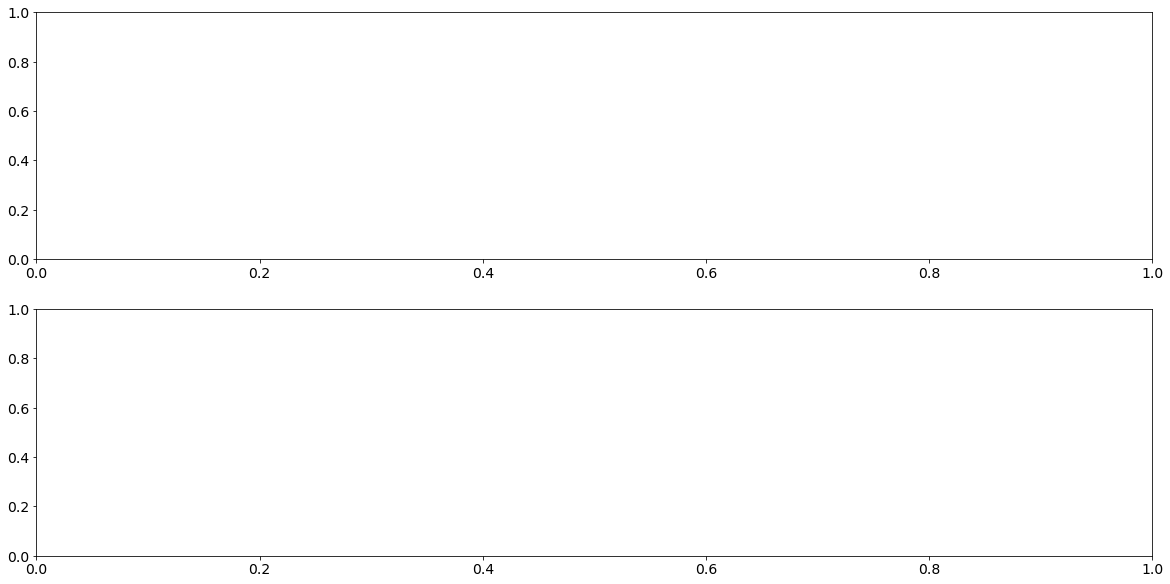

In [5]:

"""機器のパラメータ"""
'''Anritsuネトアナ(MS46122B)'''
#通信パラメータ（いじらなくてよい）
from cmath import phase


ip = "192.168.1.74" #IPアドレス(Anritsuのソフトウェアから確認できる)
# ip = "133.1.194.69" #IPアドレス(Anritsuのソフトウェアから確認できる)
send_port = 5001 #ソケットを送信するポート番号
recv_port = 2056 #ソケットを受信するポート番号

#機器のパラメータ
na_start_freq = readout_freq*1E9 #Network analyzer sweep start frequency (Hz)
na_end_freq = na_start_freq + 50   #Network analyzer sweep end frequency (Hz)
na_span_freq = na_end_freq - na_start_freq #Sweep frequency span
na_power = "LOW" #Output power (LOW or High)
na_point = 500   #Number of measurement points
na_ifbw = 10     #IFBW (Hz)
na_avg = 10      #Average (set from 1 to 1024)
na_avg_switch = "OFF"  #Average switch (ON or OFF)
na_phase_offset = 100  #Phase offset (degrees)
na_sweep_mode = "SING" #Number of sweeps


# '''Vaunix 信号発生器(LMS-183)'''
# #通信パラメータ
# serial_number_sg = 24451

#機器のパラメータ
# swp_start_freq = 8000.0e6 #Hz, sweep start frequency
# swp_end_freq = 9000.0e6 #Hz, sweep end frequency
# power_level = -30.0 #dBm, power
sweep_time = 51.27 #s, sweep time
time_list = np.linspace(0,sweep_time,na_point)

# '''Vaunix 可変アテネータ(LDA-133)'''
# #通信パラメータ
# serial_number_att = 28429

"""機器と接続"""
'''Anritsu ネトアナ'''
vna = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
vna.connect((ip, send_port))

# '''Vaunix 信号発生器'''
# vaunix_lms183dx = VaunixLMS183DX(
#     serial_number_sg
# )

# '''Vaunix 可変アテネータ'''
# vaunix_lda133 = VaunixLDA133(
#     serial_number_att
# )

"""キャリブレーション"""
vna.send(str.encode("SENS1:CORR:COEF:CAL:FILE 'G:\マイドライブ\RyoyaOhashi\CW測定\SetupFile#1.chx'"))

"""グラフの定義"""
plt.rcParams["font.size"] = 14 #まとめてフォントサイズを変える
fig = plt.figure(figsize=(20,10))
ax1 = plt.subplot(2, 1, 1)
ax2 = plt.subplot(2, 1, 2)

"""信号発生器のパワーをfor文回す"""

#信号発生器の掃引パワーリスト
power_list = np.arange(-70, -75, -5) 
# power_list = np.arange(-20, -25, -5) 

i=0
freq={}
mag={}
phase_deg={}
phase_rad={}

for power in power_list:

    # '''Vaunix 可変アテネータ'''
    # vaunix_lda133.set_att(att)

    '''Anritsu ネトアナ'''
    vna.send(str.encode(f"SENS:FREQ:SPAN {na_span_freq}\n"))  #スイープ範囲の設定
    vna.send(str.encode(f"SENS:FREQ:STAR {na_start_freq}\n")) #スイープする周波数帯域の開始周波数を設定
    vna.send(str.encode(f"SENS:FREQ:STOP {na_end_freq}\n"))   #スイープする周波数帯域の終了周波数を設定
    vna.send(str.encode(f"SOUR:POW {na_power}\n"))            #パワー
    vna.send(str.encode(f"SENS:SWEEP:POINT {na_point}\n"))    #測定ポイント数
    vna.send(str.encode(f"SENS:BAND {na_ifbw}\n"))            #IFBW
    vna.send(str.encode(f"SENS:AVER:COUN {na_avg}\n"))        #Average
    vna.send(str.encode(f"SENS:AVER {na_avg_switch}\n"))      #AverageのON OFF
    vna.send(str.encode(f"CALC:REF:EXT:PORT1:PHA {na_phase_offset}\n")) #Phase Offset
    vna.send(str.encode(f"SENS:HOLD:FUNC {na_sweep_mode}\n")) #スイープモードの設定

    # '''Vaunix 信号発生器'''
    # # vaunix_lms183dx.set_start_frequency(swp_start_freq) #スイープ開始周波数
    # # vaunix_lms183dx.set_end_frequency(swp_end_freq)     #スイープ終了周波数
    # vaunix_lms183dx.set_power_level(power)        #パワー
    # vaunix_lms183dx.set_sweep_time(sweep_time)          #スイープ時間
    # vaunix_lms183dx.set_sweep_mode(False)               #One Time Sweep

    # """測定の開始"""
    # vna.send(str.encode("SENS:HOLD:FUNC SING\n"))
    # vaunix_lms183dx.on()
    # vaunix_lms183dx.start_sweep(True)

    """スイープ終わるまで待つ"""
    time.sleep(sweep_time + 10)

    # """機器との接続を終了"""
    # vaunix_lms183dx.off()

    """データ取得"""
    now = datetime.datetime.now()
    filename = now.strftime(f'%Y%m%d__%H%M%S_{readout_freq}_GHz') + '.csv'
    # filename = now.strftime(f'%Y%m%d__%H%M%S_{readout_freq}_GHz_{power}_dBm') + '.csv'
    vna.send(str.encode(f'MMEM:STOR "C:/Users/super/Desktop/RyoyaOhashi_C/{filename}"\n')) #Gドライブは保存できないので，Cドライブ(ローカル)に保存する

    """データの描画"""
    #測定データの読み込み
    time.sleep(5.0) #データが保存される前に読み込むとエラーになる．
    csvname = f"C:/Users/super/Desktop/RyoyaOhashi_C/{filename}" #データ取得で指定したCドライブへのパスを指定する
    freq[power], mag[power], phase_deg[power] = np.loadtxt(csvname, skiprows=17, usecols=[1, 2, 3], delimiter=',', unpack=True)
    phase_rad[power] = phase_deg[power] * np.pi / 180

    #信号発生器の掃引周波数リスト
    # diff = swp_end_freq - swp_start_freq
    # delta_f = diff / 500
    # freq = [i for i in np.arange(swp_start_freq, swp_end_freq, delta_f)]
    # freq_MHz = np.array(freq) / 1e6 # MHz単位に変更



    #測定データのプロット
    ax1.plot(freq[power], mag[power], label = f"Signal power : {power} dBm")
    ax2.plot(freq[power], phase_rad[power] - 2*i, label = f"Signal power : {power} dBm")
    # ax1.plot(freq_MHz, mag[power], label = f"Signal power : {power} dBm")
    # ax2.plot(freq_MHz, phase_rad[power] - 2*i, label = f"Signal power : {power} dBm")
    i+=1

ax1.set_title("Drive Frequency = " + str(readout_freq), size=22)
ax1.set_xlabel("time / s", size = 24)
ax1.set_ylabel("Magnitude / dB", size = 24)
ax1.legend() 
plt.tick_params(labelsize=18)
ax1.grid()

# ax2.set_title("Drive Frequency = " + str(readout_freq), size=22)
ax2.set_xlabel("time / s", size = 24)
ax2.set_ylabel("Phase / rad", size = 24)
ax2.legend() 
plt.tick_params(labelsize=18)
ax2.grid()

# """設定されたパラメータの出力"""
# print("Vaunix 信号発生器のパラメータ：")
# print("Start Frequency : ", vaunix_lms183dx.get_start_frequency()/1e9, "GHz")
# print("End Frequency : ", vaunix_lms183dx.get_end_frequency()/1e9, "GHz")
# # print("Power Level : ", vaunix_lms183dx.get_power_level(), "dBm")
# print("Sweep Time : ", vaunix_lms183dx.get_sweep_time(), "s")
# # print("")
# print("Vaunix 可変アテネータのパラメータ : ")
# print("attenuation : ", vaunix_lda133.get_att(), "dB")

In [4]:
"""magとphase_radを辞書型から2次元リストに変更"""

mag_2D_list = []
phase_2D_list = []

for power in power_list:
    mag_2D_list.append(mag[power])
    phase_2D_list.append(phase_rad[power])


"""カラーマップに描画"""

X, Y = np.meshgrid(freq_MHz, power_list)
Z_mag = mag_2D_list
Z_phase = phase_2D_list
        
# グラフ描画
fig, axes = plt.subplots(figsize=(18,6), ncols=2, nrows=1)
im0 = axes[0].pcolormesh(X, Y, Z_mag)
axes[0].set_xlabel("Drive frequency / MHz")
axes[0].set_ylabel("Drive power / dBm")
axes[0].invert_yaxis()

im1 = axes[1].pcolormesh(X, Y, Z_phase)
axes[1].set_xlabel("Drive frequency / MHz")
axes[1].set_ylabel("Drive power / dBm")
axes[1].invert_yaxis()

cbar0 = fig.colorbar(im0, ax=axes[0])
cbar0.set_label("Magnitude of S21")
cbar1 = fig.colorbar(im1, ax=axes[1])
cbar1.set_label("Phase of S21")
fig.tight_layout() # これが無いと表示が少し崩れる

plt.show()

KeyError: -70

### Qubit周波数の解析
着目したいドライブパワーと周波数範囲を指定し, 共振点がディップかピークかによってコメントアウトを付け替える.  
f_geとf_efを出力し, 次のセル中の変数に代入することで, 非調和度が出力される. 

In [7]:
"""データの解析"""

power = -70 #見たいドライブパワー[dBm]
freq_MHz_min, freq_MHz_max = 8700, 8800 #見たい周波数範囲[MHz]

# freqに最も近い要素のindexを返す関数
def get_index(freq_list, freq):
    diff_array = np.abs(np.array(freq_list) - freq)
    closest_index = np.argmin(diff_array)
    return closest_index

#周波数範囲に対応する要素番号のスライス
f_range = np.s_[get_index(freq_MHz, freq_MHz_min) : get_index(freq_MHz, freq_MHz_max)]

mag_ = mag[power]
phase_rad_ = phase_rad[power]
index = np.argmin(phase_rad_[f_range]) # ディップを検知したいならこちら
#index = np.argmax(phase_rad_[f_range]) # ピークを検知したいならこちら
# index = np.argmin(mag_[f_range]) # magで探索
qubit_freq = freq_MHz[f_range][index]
print("Qubitの周波数：", qubit_freq, "MHz")


Qubitの周波数： 8772.0 MHz


In [8]:
f_ge = 8756
f_ef = 8336
alpha = f_ef - f_ge
print("非調和度:", alpha, "MHz")

非調和度: -420 MHz
